# Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

**For sure it is a computer vision model.**

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

**(5->1, 5->1)**

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

**accuracy = acc1 + acc2 / 2**
**where acc1 = (correct1/total) and acc2 = (correct2/total)**

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

# Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.nn import fractional_max_pool
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt

2025-01-08 10:01:16.761336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736359276.846650   84653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736359276.872064   84653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 10:01:17.085416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# First classifier: "airplane", "automobile", "bird", "cat", "deer"
# Second classifier: "dog", "frog", "horse", "ship", "truck"
# IDEA: extract the features with a CNN backbone and feed them to two seperate FCN classifiers. How about backpropogation?
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Normalizing to range (0,1)
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [3]:
# No validation set!
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

**Model input: (B x X1\*X2)**
**Model output: (B x Y1 x Y2)**

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [4]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  # Convert the integer labels into one hot encoded vectors for cross entropy loss
  # Careful: since there are two different sets of labels, I need to code two seperate outputs with seperate cross entropy losses
  # Keras (TF) can handle this with: model = models.Model(inputs=merged_input_image, outputs=[output1, output2])
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    # Random image selections
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    # Average image production
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = [Y1_cat[num1],Y2_cat[num2]]

    yield x_data, y_data

In [5]:
# Toy solution!
# In TensorFlow 2.x, tf.keras is the official Keras implementation that runs on top of TensorFlow, utilizing TensorFlow's functionalities for training, 
# backpropagation, and execution.

# from tensorflow.keras import layers, models

# # Model setup (with the Functional API, so previous layer is in parenthesis)
# input_image = layers.Input(shape=(32, 32, 3))  # CIFAR-10 images

# x = layers.Conv2D(32, (3, 3), activation='relu')(input_image)
# x = layers.MaxPooling2D()(x)
# x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# x = layers.MaxPooling2D()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation='relu')(x)

# # Two output layers
# output1 = layers.Dense(5, activation='softmax', name='output1')(x)  # For first 5 classes
# output2 = layers.Dense(5, activation='softmax', name='output2')(x)  # For second 5 classes

# model = models.Model(inputs=input_image, outputs=[output1, output2])

# # Compile the model
# model.compile(optimizer='adam',
#               loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
#               metrics={'output1': 'accuracy', 'output2': 'accuracy'})


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [6]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: deer, second = frog


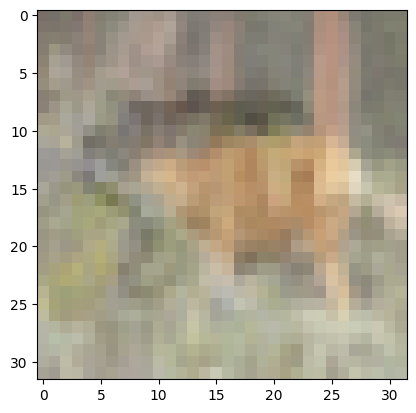

In [7]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [8]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [9]:
def random_model(x):
  #the random model ignores the input x and return a pair of random classes
  # 10,000 examples in a 2 column array between 0 and 4 inclusive
  return(np.random.randint(0,5,(10000,2)))

In [10]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [11]:
eval_model(random_model)

np.float64(0.19885)

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [12]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.20056000000000002
standard deviation =  0.002620763247605547


# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!



First I googled CIFAR-10 best accuracy and I fell upon a reddit post about a person trying to train it as fast as possible, [here](https://github.com/tysam-code/hlb-CIFAR10). Since I am not interested in light speed CIFAR-10, I googled only CIFAR-10 and arrived to the main website for this [dataset](https://www.cs.toronto.edu/~kriz/cifar.html). From there, I found a non-working link to Rodrigo Benenson since github.com has been deprecated and is now github.io, changing this and selecting "who is the best in CIFAR-10 ?" brought me to the [world rankings](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). Now I will read these papers in order. The first is [Fractional Max Pooling](https://arxiv.org/abs/1412.6071), with an accuracy of 96.53%. As I read this, I think, is my task the same? As a human, can I learn to distinguish the two classes? For sure, I will have to use the generator to see.


In [31]:
# Define my fractional pooling model

class FMP(Model):
    def __init__(self):
        super(FMP, self).__init__()
        # Input
        #self.input_layer = layers.InputLayer(shape=(32, 32, 3))  # For CIFAR-10 images

        # Four convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(10, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(20, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(30, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(40, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(50, (1, 1), activation=LeakyReLU())

        # Three fractional max pooling layers
        self.pooling_ratio1 = [1.0, 3/2, 3/2, 1.0]
        self.pooling_ratio2 = [1.0, 6/4, 6/4, 1.0]
        self.pooling_ratio3 = [1.0, 10/7, 10/7, 1.0]

        # Linearly increasing dropout in the hidden layers
        #self.dropout1 = layers.Dropout(0.0)  # 0% dropout in the first hidden layer
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Classifier
        self.fc1 = layers.Dense(10, activation='softmax')  # CIFAR-10 (10 classes)

    def call(self, inputs):
        # Input
        #x = self.input_layer(inputs)

        # Feature Extractor
        x = self.conv1(inputs)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True)
        x = self.conv2(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True)
        x = self.conv3(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True)
        x = self.conv4(x)
        x = self.conv5(x)

        # Classifier
        x = layers.Flatten()(x)
        x = self.dropout(x)
        x = self.fc1(x)  # CIFAR-10

        return x

K.clear_session()
model = FMP()
model.build(input_shape=(None, 32, 32, 3))  # Adjust if needed
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'fmp', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (1, 31, 31, 10)        │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 19, 19, 20)        │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 11, 11, 30)        │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 6, 6, 40)          │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 6, 6, 50)          │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 10)                │        18,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,280 (110.47 KB)

 Trainable params: 28,280 (110.47 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
Y_cat = tf.keras.utils.to_categorical(cifar10_y_train, num_classes=10)
Y_cat_test = tf.keras.utils.to_categorical(cifar10_y_test, num_classes=10)
print(cifar10_x_train.shape)
print(Y_cat.shape)

(50000, 32, 32, 3)
(50000, 10)


In [33]:
history = model.fit(x=cifar10_x_train, y=Y_cat, epochs=1, batch_size=2048)

2025-01-08 09:48:36.465343: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : INVALID_ARGUMENT: Detected unsupported operations when trying to compile graph __inference_one_step_on_data_10169[] on XLA_GPU_JIT: FractionalMaxPool (No registered 'FractionalMaxPool' OpKernel for XLA_GPU_JIT devices compatible with node {{node fmp_1/FractionalMaxPool}}){{node fmp_1/FractionalMaxPool}}
The op is created at: 
File "usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "usr/lib/python3.10/runpy.py", line 86, in _run_code
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
File "home/nicolas/Github/image-seperation/venv

InvalidArgumentError: Graph execution error:

Detected at node fmp_1/FractionalMaxPool defined at (most recent call last):
<stack traces unavailable>
Detected at node fmp_1/FractionalMaxPool defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_10169[] on XLA_GPU_JIT: FractionalMaxPool (No registered 'FractionalMaxPool' OpKernel for XLA_GPU_JIT devices compatible with node {{node fmp_1/FractionalMaxPool}}){{node fmp_1/FractionalMaxPool}}
The op is created at: 
File "usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "usr/lib/python3.10/runpy.py", line 86, in _run_code
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
File "usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "tmp/ipykernel_61376/2404114935.py", line 1, in <module>
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 59, in train_step
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 908, in __call__
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "home/nicolas/Github/image-seperation/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "tmp/ipykernel_61376/4221719843.py", line 34, in call
	tf2xla conversion failed while converting __inference_one_step_on_data_10169[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_10258]

In [77]:
# Evaluate
def evaluate(model, x, y):
    loss, accuracy = model.evaluate(x, y)
    print(f"{model.name} Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
    return accuracy

evaluate(model, x=cifar10_x_test, y=Y_cat_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0996 - loss: 2.3098
fmp Loss: 2.3086, Accuracy: 10.16%


0.10159999877214432

Implementing this, I feel like the convolutional layers would benefit from being more complex and so I use this [person's](https://github.com/WingsBrokenAngel/fractional_max_pooling_and_recurrent_convolutional_neural_network) filters.

In [80]:
class FMP1(Model):
    def __init__(self, FILTERS):
        super(FMP1, self).__init__()
        # Parameters
        self.filters = FILTERS

        # Four convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(10*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(20*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(30*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(40*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(50*FILTERS, (1, 1), activation=LeakyReLU())

        # Three fractional max pooling layers
        self.pooling_ratio1 = [1.0, 3/2, 3/2, 1.0]
        self.pooling_ratio2 = [1.0, 6/4, 6/4, 1.0]
        self.pooling_ratio3 = [1.0, 10/7, 10/7, 1.0]

        # Linearly increasing dropout in the hidden layers
        #self.dropout1 = layers.Dropout(0.0)  # 0% dropout in the first hidden layer
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Classifier
        self.fc1 = layers.Dense(10, activation='softmax')  # CIFAR-10 (10 classes)

    def call(self, inputs):
        # Input
        #x = self.input_layer(inputs)

        # Feature Extractor
        x = self.conv1(inputs)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True)
        x = self.conv2(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True)
        x = self.conv3(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True)
        x = self.conv4(x)
        x = self.conv5(x)

        # Classifier
        x = layers.Flatten()(x)
        x = self.dropout(x)
        x = self.fc1(x)  # CIFAR-10

        return x

#K.clear_session()
model = FMP1(FILTERS=3)
model.build(input_shape=(None, 32, 32, 3))  # Adjust if needed
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/home/nicolas/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'fmp1_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp1_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (1, 31, 31, 30)        │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (1, 19, 19, 60)        │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (1, 11, 11, 90)        │        21,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (1, 6, 6, 120)         │        43,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (1, 6, 6, 150)         │        18,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 10)                │        54,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,820 (565.70 KB)

 Trainable params: 144,820 (565.70 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
history = model.fit(x=cifar10_x_train, y=Y_cat, epochs=5, batch_size=2048)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.2143 - loss: 2.1583
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.3303 - loss: 1.8607
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.3843 - loss: 1.6899
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.4289 - loss: 1.5799
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4360 - loss: 1.5821


In [84]:
evaluate(model, x=cifar10_x_test, y=Y_cat_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4973 - loss: 1.4186
fmp1_2 Loss: 1.4227, Accuracy: 48.98%


0.48980000615119934

I decide to implement a network as similar as possible, now that I understand the architecture better!

In [ ]:
class FMP2(Model):
    def __init__(self):
        super(FMP2, self).__init__()
        # Input layer size 36x36

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU()) # 36x36 # comment left here to show how the first time I calculated them wrong, both by thinking the input is 36 when it is 32 and forgetting conv takes 1 
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU()) # 25x25
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU()) # 18x18
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU()) # 13x13
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU()) # 9x9
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 6x6

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Classifier 
        self.fc = layers.Dense(10, activation='softmax')  # CIFAR-10 (10 classes)

    def call(self, inputs):
        # Feature Extractor
        x = self.conv1(inputs) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        # IDEA: dropout here at 25%
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout(x)
        x = self.fc(x)  # CIFAR-10

        return x

K.clear_session()
model = FMP2()
model.build(input_shape=(None, 32, 32, 3))  # Adjust if needed
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

W0000 00:00:1736359292.802755   84653 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/nicolas/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'fmp2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (1, 31, 31, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 21, 21, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 14, 14, 96)        │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 9, 9, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 5, 5, 160)         │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (1, 3, 3, 192)         │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (1, 1, 1, 192)         │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (1, 1, 1, 192)         │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 10)                │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
Y_cat_train = tf.keras.utils.to_categorical(cifar10_y_train, num_classes=10)
Y_cat_test = tf.keras.utils.to_categorical(cifar10_y_test, num_classes=10)

history = model.fit(x=cifar10_x_train, y=Y_cat_train, epochs=100, batch_size=1000)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.1167 - loss: 3.4283
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2219 - loss: 2.1018
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2716 - loss: 1.9459
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.3036 - loss: 1.8545
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3509 - loss: 1.7390
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3450 - loss: 1.7441
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.3815 - loss: 1.6585
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.3970 - loss: 1.6114
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4307 - loss: 1.5329
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4368 - loss: 1.5154
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4658 - loss: 1.4397
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step

In [ ]:
evaluate(model, x=cifar10_x_test, y=Y_cat_test)

Without checkpoints or early stop, the model clearly overfit!

Now I realize I forgot to read section 4.4 and implement that network!